Importing necessary liabraries 
using yfinance to donwload the dataset

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Bidirectional, Dense, Concatenate
import plotly.graph_objects as go
import matplotlib.pyplot as plt

Loading the datset

In [2]:
# Download stock data for HDFCBANK
# HDFCBANK stock ticker symbol for NSE (National Stock Exchange)
ticker = "HDFCBANK.NS"
# Adjust start and end dates as needed
data = yf.download(ticker, start="2010-01-01", end="2023-07-11")

# Prepare the data
df = data.reset_index()[['Date', 'Open', 'High', 'Low', 'Close']]
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)


[*********************100%***********************]  1 of 1 completed


example of dataset

In [3]:
df

,Open,High,Low,Close
Date,,,,
2010-01-04,170.000000,172.850006,169.255005,170.570007
2010-01-05,171.000000,172.500000,170.500000,170.720001
2010-01-06,171.399994,172.000000,168.809998,170.835007
2010-01-07,176.839996,176.839996,170.160004,171.279999
2010-01-08,171.199997,172.339996,170.100006,171.505005
...,...,...,...,...
2023-07-04,1723.449951,1747.000000,1713.800049,1728.199951
2023-07-05,1716.250000,1720.000000,1668.550049,1673.300049
2023-07-06,1673.000000,1687.849976,1660.400024,1675.000000


Visualization of dataset

<AxesSubplot:xlabel='Date'>

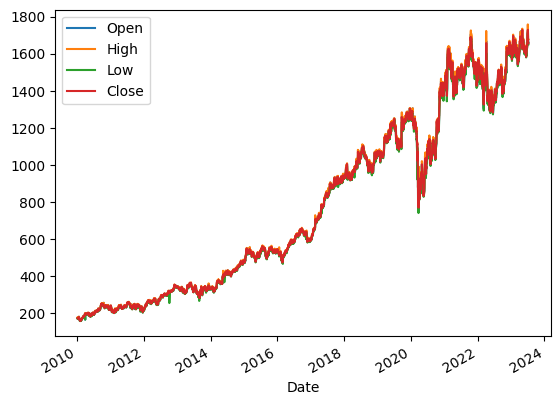

In [6]:
df.plot()

<AxesSubplot:xlabel='Date'>

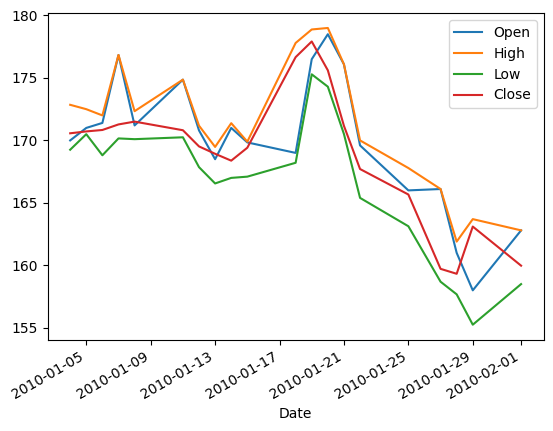

In [7]:
df[:20].plot()

In [8]:


# Split data into training and testing sets
train_data = df[:int(0.8*len(df))]
test_data = df[int(0.8*len(df)):]

# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_train_data = scaler.fit_transform(train_data)
scaled_test_data = scaler.transform(test_data)


def create_sequences(data, input_seq_length, seq_length):
    X = []
    y = []
    for i in range(len(data)-input_seq_length-seq_length):
        X.append(data[i:i+input_seq_length, :])
        y.append(data[i+input_seq_length:i+input_seq_length+seq_length, :])
    return np.array(X), np.array(y)


# Set input sequence length and prediction sequence length
input_seq_length = 10
seq_length = 5

# Create training sequences
X_train, y_train = create_sequences(
    scaled_train_data, input_seq_length, seq_length)

# Create testing sequences
X_test, y_test = create_sequences(
    scaled_test_data, input_seq_length, seq_length)

# Reshape the input data to fit the LSTM model
X_train = np.reshape(
    X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2]))
X_test = np.reshape(
    X_test, (X_test.shape[0], X_test.shape[1], X_test.shape[2]))
y_train=y_train.reshape(-1,seq_length * 4)
y_test = y_test.reshape(-1,seq_length*4)

In [9]:
print(np.shape(X_train),np.shape(X_test),np.shape(y_train),np.shape(y_test))

(2654, 10, 4) (653, 10, 4) (2654, 20) (653, 20)


In [19]:
df

,Open,High,Low,Close
Date,,,,
2010-01-04,170.000000,172.850006,169.255005,170.570007
2010-01-05,171.000000,172.500000,170.500000,170.720001
2010-01-06,171.399994,172.000000,168.809998,170.835007
2010-01-07,176.839996,176.839996,170.160004,171.279999
2010-01-08,171.199997,172.339996,170.100006,171.505005
...,...,...,...,...
2023-07-04,1723.449951,1747.000000,1713.800049,1728.199951
2023-07-05,1716.250000,1720.000000,1668.550049,1673.300049
2023-07-06,1673.000000,1687.849976,1660.400024,1675.000000


In [3]:
from tensorflow.keras import backend as K


def custom_loss(y_true, y_pred):
    mse = K.mean(K.square(y_true - y_pred))
    mae = K.mean(K.abs(y_true - y_pred))
    custom_loss = 0.7 * mse + 0.3 * mae
    return custom_loss


Epoch 1/100
42/42 [==============================] - 3s 9ms/step - loss: 0.0937
Epoch 2/100
42/42 [==============================] - 0s 10ms/step - loss: 0.0069
Epoch 3/100
42/42 [==============================] - 0s 10ms/step - loss: 0.0050
Epoch 4/100
42/42 [==============================] - 0s 9ms/step - loss: 0.0049
Epoch 5/100
42/42 [==============================] - 0s 8ms/step - loss: 0.0048
Epoch 6/100
42/42 [==============================] - 0s 8ms/step - loss: 0.0044
Epoch 7/100
42/42 [==============================] - 0s 8ms/step - loss: 0.0042
Epoch 8/100
42/42 [==============================] - 0s 9ms/step - loss: 0.0044
Epoch 9/100
42/42 [==============================] - 0s 9ms/step - loss: 0.0042
Epoch 10/100
42/42 [==============================] - 0s 9ms/step - loss: 0.0042
Epoch 11/100
42/42 [==============================] - 0s 9ms/step - loss: 0.0045
Epoch 12/100
42/42 [==============================] - 0s 9ms/step - loss: 0.0046
Epoch 13/100
42/42 [===============

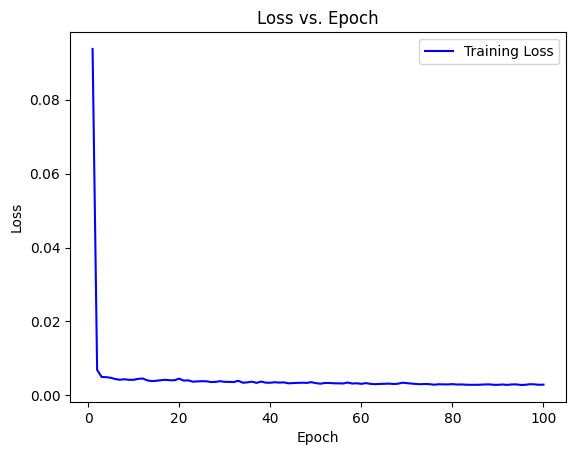

In [12]:
# Build the LSTM model using the functional API
inputs = Input(shape=(input_seq_length, 4))
lstm1 = LSTM(50, return_sequences=True)(inputs)
lstm2 = LSTM(50, return_sequences=False)(lstm1)
dense1 = Dense(25)(lstm2)
outputs = Dense(seq_length * 4)(dense1)
lstm_model = Model(inputs=inputs, outputs=outputs)


# Compile the LSTM model
lstm_model.compile(optimizer='adam',  loss=custom_loss)

# Train the LSTM model
history_lstm= lstm_model.fit(X_train, y_train, batch_size=64, epochs=100)

# Retrieve the loss history from the history object
loss = history_lstm.history['loss']

# Retrieve the number of epochs
epochs = range(1, len(loss) + 1)

# Plot the loss vs. epoch graph
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.title('Loss vs. Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


Epoch 1/100
42/42 [==============================] - 5s 17ms/step - loss: 0.0518
Epoch 2/100
42/42 [==============================] - 1s 18ms/step - loss: 0.0052
Epoch 3/100
42/42 [==============================] - 1s 19ms/step - loss: 0.0049
Epoch 4/100
42/42 [==============================] - 1s 16ms/step - loss: 0.0046
Epoch 5/100
42/42 [==============================] - 1s 17ms/step - loss: 0.0045
Epoch 6/100
42/42 [==============================] - 1s 18ms/step - loss: 0.0044
Epoch 7/100
42/42 [==============================] - 1s 16ms/step - loss: 0.0044
Epoch 8/100
42/42 [==============================] - 1s 16ms/step - loss: 0.0045
Epoch 9/100
42/42 [==============================] - 1s 17ms/step - loss: 0.0042
Epoch 10/100
42/42 [==============================] - 1s 17ms/step - loss: 0.0041
Epoch 11/100
42/42 [==============================] - 1s 17ms/step - loss: 0.0042
Epoch 12/100
42/42 [==============================] - 1s 16ms/step - loss: 0.0041
Epoch 13/100
42/42 [=====

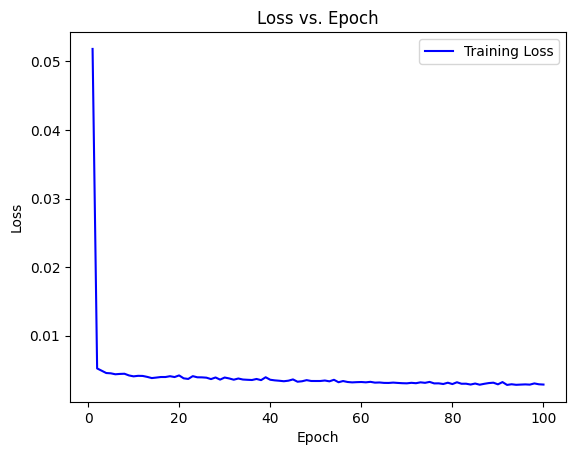

In [13]:
# Build the BiLSTM model using the functional API
inputs = Input(shape=(input_seq_length, 4))
bilstm1 = Bidirectional(LSTM(50, return_sequences=True))(inputs)
bilstm2 = Bidirectional(LSTM(50))(bilstm1)
dense1 = Dense(25)(bilstm2)
outputs = Dense(seq_length * 4)(dense1)
bilstm_model = Model(inputs=inputs, outputs=outputs)

# Compile the BiLSTM model
bilstm_model.compile(optimizer='adam',  loss=custom_loss)

# Train the BiLSTM model
history_bilstm = bilstm_model.fit(X_train, y_train, batch_size=64, epochs=100)


# Retrieve the loss history from the history object
loss = history_bilstm.history['loss']

# Retrieve the number of epochs
epochs = range(1, len(loss) + 1)

# Plot the loss vs. epoch graph
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.title('Loss vs. Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [8]:
# Make predictions using the LSTM model
lstm_predictions = lstm_model.predict(X_train)
lstm_predictions = lstm_predictions.reshape(-1,5,4)
# Make predictions using the BiLSTM model
bilstm_predictions = bilstm_model.predict(X_train)
bilstm_predictions= bilstm_predictions.reshape(-1,5,4)

83/83 [==============================] - 2s 4ms/step


Epoch 1/100
42/42 [==============================] - 7s 17ms/step - loss: 0.0634
Epoch 2/100
42/42 [==============================] - 1s 17ms/step - loss: 0.0038
Epoch 3/100
42/42 [==============================] - 1s 17ms/step - loss: 0.0033
Epoch 4/100
42/42 [==============================] - 1s 17ms/step - loss: 0.0038
Epoch 5/100
42/42 [==============================] - 1s 17ms/step - loss: 0.0032
Epoch 6/100
42/42 [==============================] - 1s 17ms/step - loss: 0.0035
Epoch 7/100
42/42 [==============================] - 1s 17ms/step - loss: 0.0033
Epoch 8/100
42/42 [==============================] - 1s 17ms/step - loss: 0.0035
Epoch 9/100
42/42 [==============================] - 1s 17ms/step - loss: 0.0031
Epoch 10/100
42/42 [==============================] - 1s 17ms/step - loss: 0.0031
Epoch 11/100
42/42 [==============================] - 1s 17ms/step - loss: 0.0032
Epoch 12/100
42/42 [==============================] - 1s 17ms/step - loss: 0.0035
Epoch 13/100
42/42 [=====

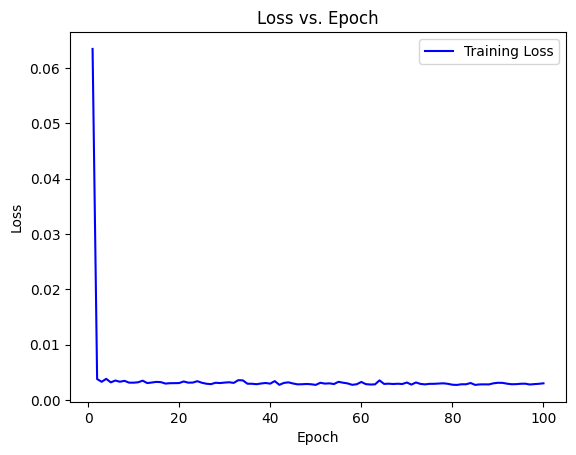

In [9]:
# Define inputs for LSTM and BiLSTM models
lstm_inputs = Input(shape=(seq_length, 4))
bilstm_inputs = Input(shape=(seq_length, 4))

# LSTM model
lstm1 = LSTM(128, return_sequences=True)(lstm_inputs)
lstm2 = LSTM(64, return_sequences=False)(lstm1)
lstm_outputs = Dense(32)(lstm2)

# BiLSTM model
bilstm1 = Bidirectional(LSTM(128, return_sequences=True))(bilstm_inputs)
bilstm2 = Bidirectional(LSTM(64, return_sequences=False))(bilstm1)
bilstm_outputs = Dense(32)(bilstm2)

# Concatenate LSTM and BiLSTM outputs
concatenated = Concatenate()([lstm_outputs, bilstm_outputs])

# Additional dense layers for further prediction improvement
dense1 = Dense(64)(concatenated)
dense2 = Dense(32)(dense1)

# Output layer
outputs = Dense(seq_length * 4)(dense2)

# Combined model
combined_model = Model(inputs=[lstm_inputs, bilstm_inputs], outputs=outputs)

# Compile the combined model
combined_model.compile(optimizer='adam',  loss=custom_loss)

# Train the combined model
history_combined=combined_model.fit([lstm_predictions, bilstm_predictions],
                   y_train, batch_size=64, epochs=100)

# Retrieve the loss history from the history object
loss = history_combined.history['loss']

# Retrieve the number of epochs
epochs = range(1, len(loss) + 1)

# Plot the loss vs. epoch graph
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.title('Loss vs. Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [14]:

# Make predictions using the LSTM model
lstm_predictions = lstm_model.predict(X_test)

# Make predictions using the BiLSTM model
bilstm_predictions = bilstm_model.predict(X_test)

# Make predictions using the combined model"
combined_predictions = combined_model.predict(
    [lstm_predictions.reshape(-1, 5, 4), bilstm_predictions.reshape(-1, 5, 4)])


21/21 [==============================] - 0s 5ms/step


In [15]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

# Calculate RMSE
lstm_rmse = np.sqrt(mean_squared_error(y_test, lstm_predictions))
bilstm_rmse = np.sqrt(mean_squared_error(y_test, bilstm_predictions))
combined_rmse = np.sqrt(mean_squared_error(y_test, combined_predictions))

# Calculate MAE
lstm_mae = mean_absolute_error(y_test, lstm_predictions)
bilstm_mae = mean_absolute_error(y_test, bilstm_predictions)
combined_mae = mean_absolute_error(y_test, combined_predictions)

# Calculate MAPE (Mean Absolute Percentage Error)


def calculate_mape(actual, predicted):
    return np.mean(np.abs((actual - predicted) / actual)) * 100


lstm_mape = calculate_mape(y_test, lstm_predictions)
bilstm_mape = calculate_mape(y_test, bilstm_predictions)
combined_mape = calculate_mape(y_test, combined_predictions)

# Calculate R-squared (coefficient of determination)


def calculate_r_squared(actual, predicted):
    ss_residual = np.sum((actual - predicted) ** 2)
    ss_total = np.sum((actual - np.mean(actual)) ** 2)
    r_squared = 1 - (ss_residual / ss_total)
    return r_squared


lstm_r_squared = calculate_r_squared(y_test, lstm_predictions)
bilstm_r_squared = calculate_r_squared(y_test, bilstm_predictions)
combined_r_squared = calculate_r_squared(y_test, combined_predictions)

# Print the evaluation metrics
print("LSTM:")
print("RMSE:", lstm_rmse)
print("MAE:", lstm_mae)
print("MAPE:", lstm_mape)
print("R-squared:", lstm_r_squared)

print("BiLSTM:")
print("RMSE:", bilstm_rmse)
print("MAE:", bilstm_mae)
print("MAPE:", bilstm_mape)
print("R-squared:", bilstm_r_squared)

print("Combined Model:")
print("RMSE:", combined_rmse)
print("MAE:", combined_mae)
print("MAPE:", combined_mape)
print("R-squared:", combined_r_squared)


LSTM:
RMSE: 0.03470676436483218
MAE: 0.025771913897383945
MAPE: 2.1764214407135762
R-squared: 0.8393014511784067
BiLSTM:
RMSE: 0.03655185064581503
MAE: 0.027547233342629297
MAPE: 2.3135797435749814
R-squared: 0.8217611212832424
Combined Model:
RMSE: 0.03229590421999644
MAE: 0.02322144927332887
MAPE: 1.9767996413396518
R-squared: 0.8608514781497587


In [35]:
X_test[0]

array([[0.90908456, 0.91195507, 0.90272507, 0.89944654],
       [0.893366  , 0.90746796, 0.90082894, 0.89626069],
       [0.90364182, 0.92986033, 0.90184316, 0.92393029],
       [0.93159568, 0.95229631, 0.94417493, 0.95247275],
       [0.95384562, 0.96453812, 0.94814353, 0.96072133],
       [0.96603734, 0.97429664, 0.96785425, 0.97102101],
       [0.96625505, 1.00392085, 0.97945141, 1.00458251],
       [1.0088825 , 1.03524405, 1.02328239, 1.0332996 ],
       [1.04528354, 1.07798137, 1.05533997, 1.07964841],
       [1.08264249, 1.09523316, 1.07205216, 1.07641877]])

In [41]:
y_test.reshape(-1,5, 4).shape


(653, 5, 4)

In [42]:
lstm_predictions.reshape(-1,5,4).shape

(653, 5, 4)

In [47]:
df

,Open,High,Low,Close
Date,,,,
2010-01-04,170.000000,172.850006,169.255005,170.570007
2010-01-05,171.000000,172.500000,170.500000,170.720001
2010-01-06,171.399994,172.000000,168.809998,170.835007
2010-01-07,176.839996,176.839996,170.160004,171.279999
2010-01-08,171.199997,172.339996,170.100006,171.505005
...,...,...,...,...
2023-07-04,1723.449951,1747.000000,1713.800049,1728.199951
2023-07-05,1716.250000,1720.000000,1668.550049,1673.300049
2023-07-06,1673.000000,1687.849976,1660.400024,1675.000000


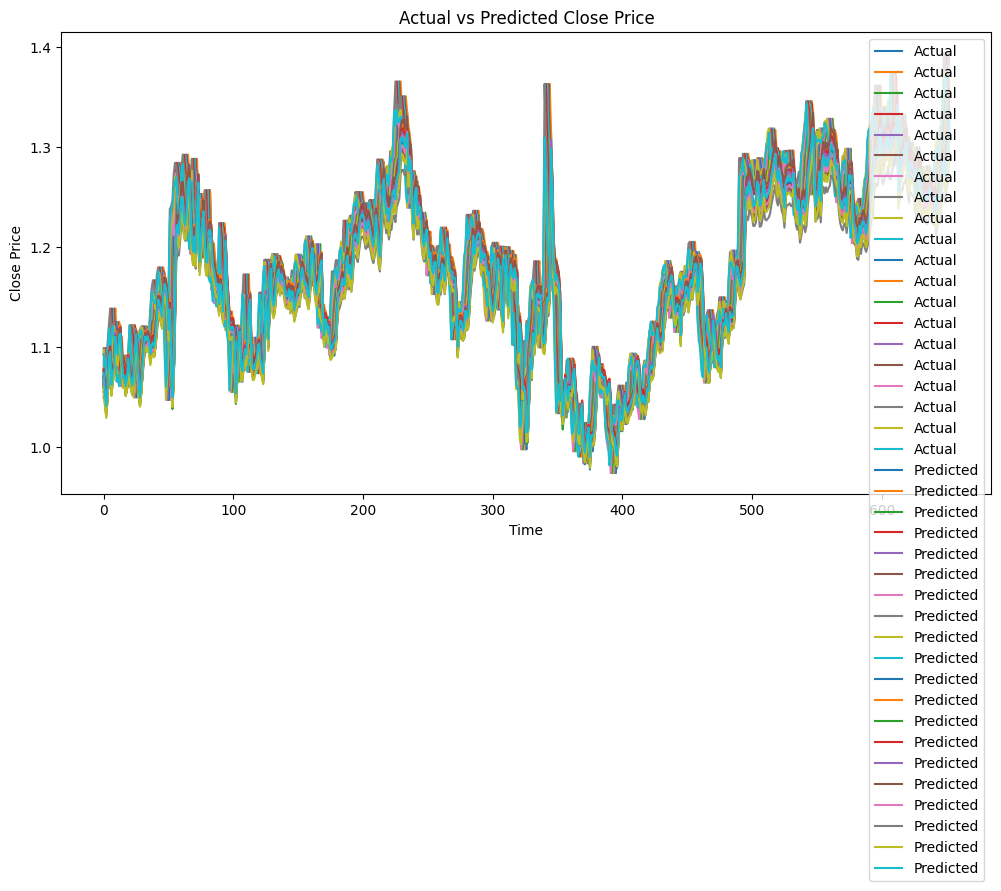

In [16]:
plt.figure(figsize=(12, 6))
plt.plot(y_test, label='Actual')
plt.plot(bilstm_predictions, label='Predicted')
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.title('Actual vs Predicted Close Price')
plt.legend()
plt.show()


In [17]:
# Create a trace for each column in y_test
actual_traces = []
predicted_traces = []

columns = ['Open', 'High', 'Low', 'Close']
colors = ['blue', 'green', 'red', 'orange']

for i, column in enumerate(columns):
    actual_trace = go.Scatter(
        x=df.index[-len(y_test):],
        y=y_test[:, i],
        mode='lines',
        name='Actual ' + column,
        line=dict(color=colors[i])
    )
    predicted_trace = go.Scatter(
        x=df.index[-len(y_test):],
        y=bilstm_predictions[:, i],
        mode='lines',
        name='Predicted ' + column,
        line=dict(color=colors[i], dash='dash')
    )
    actual_traces.append(actual_trace)
    predicted_traces.append(predicted_trace)

# Create the layout for the plot
layout = go.Layout(
    title='Actual vs Predicted Stock Prices',
    xaxis=dict(title='Time'),
    yaxis=dict(title='Price'),
    legend=dict(orientation='h'),
    height=500,
    width=800
)

# Create the figure and plot the traces
fig = go.Figure(data=actual_traces + predicted_traces, layout=layout)
fig.show()


In [18]:
# Create a trace for each column in y_test
lstm_traces = []
bilstm_traces = []
combined_traces = []

columns = ['Open', 'High', 'Low', 'Close']
colors = ['blue', 'green', 'red', 'orange']

for i, column in enumerate(columns):
    lstm_trace = go.Scatter(
        x=df.index[-len(y_test):],
        y=lstm_predictions[:, i],
        mode='lines',
        name='LSTM ' + column,
        line=dict(color=colors[i])
    )
    bilstm_trace = go.Scatter(
        x=df.index[-len(y_test):],
        y=bilstm_predictions[:, i],
        mode='lines',
        name='BiLSTM ' + column,
        line=dict(color=colors[i], dash='dot')
    )
    combined_trace = go.Scatter(
        x=df.index[-len(y_test):],
        y=combined_predictions[:, i],
        mode='lines',
        name='Combined ' + column,
        line=dict(color=colors[i], dash='dash')
    )
    lstm_traces.append(lstm_trace)
    bilstm_traces.append(bilstm_trace)
    combined_traces.append(combined_trace)

# Create the layout for the plot
layout = go.Layout(
    title='Actual vs Predicted Stock Prices',
    xaxis=dict(title='Time'),
    yaxis=dict(title='Price'),
    legend=dict(orientation='h'),
    height=500,
    width=800
)

# Create the figure and plot the traces
fig = go.Figure(data=actual_traces + lstm_traces +
                bilstm_traces + combined_traces, layout=layout)
fig.show()
